In [1]:
%reload_ext autoreload
%reload_ext autoreload

In [2]:
import time
import os
import sys
import copy
import time
import datetime
import random
import math
import warnings
from functools import partial
# warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

/home/geshi/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import numpy as np
import scipy
from scipy.stats import kendalltau
import seaborn as sns

from tqdm.notebook import tqdm, trange

In [5]:
sys.path.append("../")

In [6]:
from chaosmining.data_utils import read_formulas, create_simulation_data
from chaosmining.simulation.models import MLPRegressor
from chaosmining.simulation.functions import abs_argmax_topk
from chaosmining.utils import radar_factory

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [8]:
from captum.attr import IntegratedGradients, Saliency, DeepLift, FeatureAblation

In [9]:
import matplotlib
# mpl.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt 
from matplotlib.colors import ListedColormap

matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 5
plt.rcParams['figure.figsize'] = [4, 4]

# Generate Functions and Data

In [10]:
formulas_path = '../data/symbolic_simulation/formula.csv'

In [11]:
formulas = read_formulas(formulas_path)

In [12]:
formula_id = 14
seed = 9999
test_size = 0.2
n_steps = 20

In [13]:
num_features, function = formulas[formula_id]

In [14]:
num_noises = 200
num_data = 10000
X_var = 0.33
y_var = 0.01
X, y_true, y_noise, intercepts, derivatives, integrations = create_simulation_data(function, num_features, num_noises, num_data, X_var, y_var, n_steps=n_steps)
print('X', X.shape, 'y true', y_true.shape, 'y noise', y_noise.shape, 
      'intercepts', len(intercepts), intercepts[0].shape,
      'derivatives', len(derivatives), derivatives[0].shape, 
      'integrations', len(integrations), integrations[0].shape)

X (10000, 210) y true (10000, 1) y noise (10000, 1) intercepts 10 (10000,) derivatives 10 (10000,) integrations 10 (10000,)


In [15]:
intercepts = np.stack(intercepts, axis=1)
derivatives = np.stack(derivatives, axis=1)
integrations = np.stack(integrations, axis=1)

In [16]:
y = y_true + y_noise

In [17]:
X_train, X_test, \
y_train, y_test, \
y_true_train, y_true_test, \
intercepts_train, intercepts_test, \
derivatives_train, derivatives_test, \
integrations_train, integrations_test \
= train_test_split(X, y, y_true, intercepts, derivatives, integrations, test_size=test_size, random_state=seed)

# Training and Test a MLP

In [134]:
train_set = TensorDataset(Tensor(X_train), Tensor(y_train))
train_loader = DataLoader(train_set, batch_size=y_train.shape[0], shuffle=True)
test_set = TensorDataset(Tensor(X_test), Tensor(y_true_test))
test_loader = DataLoader(test_set, batch_size=y_test.shape[0])

In [135]:
hidden_layer_sizes = (100,100,100)
num_epochs = 1000

In [136]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [137]:
model = MLPRegressor(num_features+num_noises, hidden_layer_sizes, p=0.0)
model.to(device)
model.train()

MLPRegressor(
  (blocks): ModuleList(
    (0): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=210, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
    (1): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
    (2): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (project): Linear(in_features=100, out_features=1, bias=True)
)

In [138]:
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), 0.001)

In [139]:
trace_inds = []

In [140]:
pbar = trange(num_epochs, desc='Train', unit='epoch', initial=0, disable=True)
for epoch in pbar:  # loop over the dataset multiple times
    running_loss = 0.0
    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        # forward pass
        outputs = model(inputs)
        # defining loss
        loss = criterion(outputs, targets)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    pbar.set_postfix(loss = '%.3f' % running_loss)

    model.eval()
    with torch.no_grad():
        y_pred = model(Tensor(X_test).to(device)).detach().cpu().numpy()

    # xai = Saliency(model)
    # xai = DeepLift(model)
    # xai = FeatureAblation(model)
    xai = IntegratedGradients(model)

    xai_attr_test = xai.attribute(Tensor(X_test).to(device))
    abs_xai_attr_test = np.abs(xai_attr_test.detach().cpu().numpy()).mean(0)

    # sorted_inds = np.argsort(abs_xai_attr_test)
    # trace_inds.append(sorted_inds[:num_features])
    inds = np.argpartition(-abs_xai_attr_test, num_features)[:num_features]
    trace_inds.append(inds)

print('train loss:', running_loss)

train loss: 1.795888783817645e-05


In [141]:
last_inds = trace_inds[-1]
corrs = []

In [142]:
for inds in trace_inds:
    corr = kendalltau(inds, last_inds)
    corrs.append(corr[0])

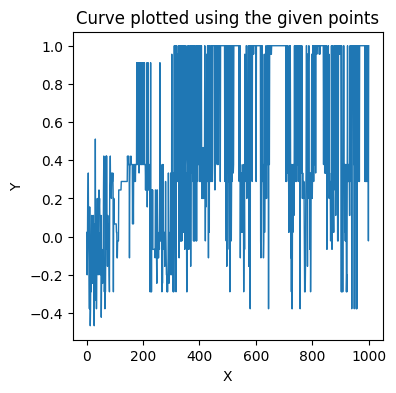

In [143]:
plt.plot(np.arange(1, len(corrs)+1), np.array(corrs))
plt.title("Curve plotted using the given points")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# Single Formula Convergence